In [2]:
import phenom

In [3]:
# Any python imports you need go here
import numpy as np
import matplotlib.pyplot as plt

# Start the Julia session
from juliacall import Main as jl

# Import `PostNewtonian` in the Julia session
jl.seval("using PostNewtonian")

In [ ]:
# documentation for jl.GWFrames.PNWaveform
# https://moble.github.io/PostNewtonian.jl/dev/interface/gwframes/#PostNewtonian.GWFrames.PNWaveform

In [159]:
def delta_from_m1_m2(m1, m2):
    return (m1 - m2) / (m1 + m2)

def gwframes_pnwaveform(M, q, chi1=np.array([0,0,0]), chi2=np.array([0,0,0]), Omega_i=0.01, approximant="TaylorT1", ell_min=2, ell_max=4, inertial=True, return_raw=False):
    """
    Omega_i: orbital angular frequency at initial instant.
        I assume this is in dimensionless units
    """
    m1, m2 = phenom.m1_m2_M_q(M, q)
    delta = delta_from_m1_m2(m1, m2)

    # Call into Julia to run some function
    w = jl.GWFrames.PNWaveform("TaylorT1", delta, chi1, chi2, Omega_i, ell_max=ell_max, inertial=inertial)

    if return_raw:
        return w
    else:
        times = w.t.to_numpy()
        hlm_array = w.data.to_numpy()

        hlm={}
        i = 0
        for l in range(ell_min, ell_max+1):
            for m in range(-l, l+1):
                key = (l,m)
                hlm[key] = hlm_array[:,i]
                # hlm[key] = (1.j)**m * hlm_array[:,i]
                i+=1

        # conventions...
        # for l in range(ell_min, ell_max+1):
        #     for m in range(-l, l+1):
        #         hlm[l,m] = -1**l * np.conj(hlm[l,-m])
        #         hlm[l,m] = (1.j)**m * hlm[l,m]
        
        # align so last time point is at 0
        times = times - times[-1]
        wf = {}
        wf['t'] = times
        wf['hlm'] = hlm
        return wf

In [168]:
M=30
q=5
chi1 = np.array([0., 0., 0.])
chi2 = np.array([0., 0., 0.])
wf = gwframes_pnwaveform(M, q, chi1=chi1, chi2=chi2)

┌ Warning: Terminating evolution because the time-step size has become very small:
│ |dt=9.971053760747622e-9| < √ϵ=1.4901161193847656e-8
│ This is only unexpected for 𝑣 ≲ 1/2; the current value is 𝑣=0.44998088867558994.
└ @ PostNewtonian /var/folders/mq/kw_39j7d7n39tm1hyxg3sfx40000gn/T/tmp.MKMvC1zp7C/packages/PostNewtonian/8L99y/src/utilities/termination_criteria.jl:121


In [169]:
wf['hlm'].keys()

dict_keys([(2, -2), (2, -1), (2, 0), (2, 1), (2, 2), (3, -3), (3, -2), (3, -1), (3, 0), (3, 1), (3, 2), (3, 3), (4, -4), (4, -3), (4, -2), (4, -1), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)])

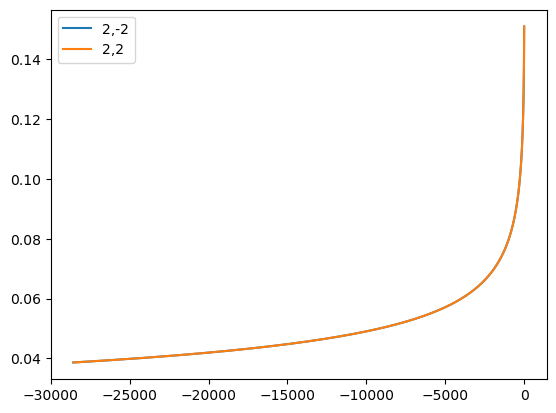

In [170]:
plt.figure()
plt.plot(wf['t'], np.abs(wf['hlm'][2,-2]), label='2,-2')
plt.plot(wf['t'], np.abs(wf['hlm'][2,2]), label='2,2')
plt.legend()
# plt.xlim(-1000, 0)

In [171]:
def compute_phase(wf):
    wf = wf.copy()
    phases = {}
    for k in wf['hlm'].keys():
        phases[k] = np.unwrap(np.angle(wf['hlm'][k]))
    wf['phase'] = phases
    return wf
    

In [172]:
wf = compute_phase(wf)

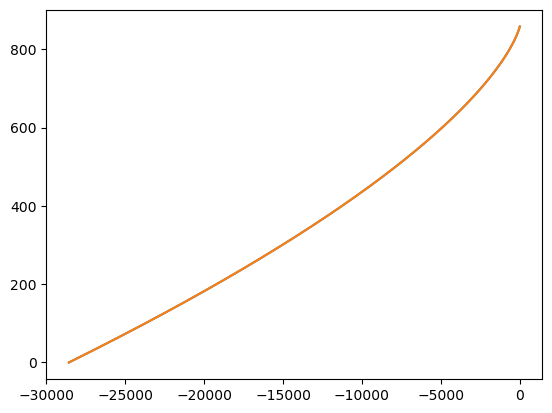

In [173]:
plt.plot(wf['t'], wf['phase'][2,2])
plt.plot(wf['t'], wf['phase'][3,2])

In [174]:
# I don't think this equation is quite correct.
# it doesn't seem to work for the (4,4) mode..
def delta_phi_fn(m):
    z = (-1)*(-1.j)**m
    return np.arctan2(z.imag, z.real)

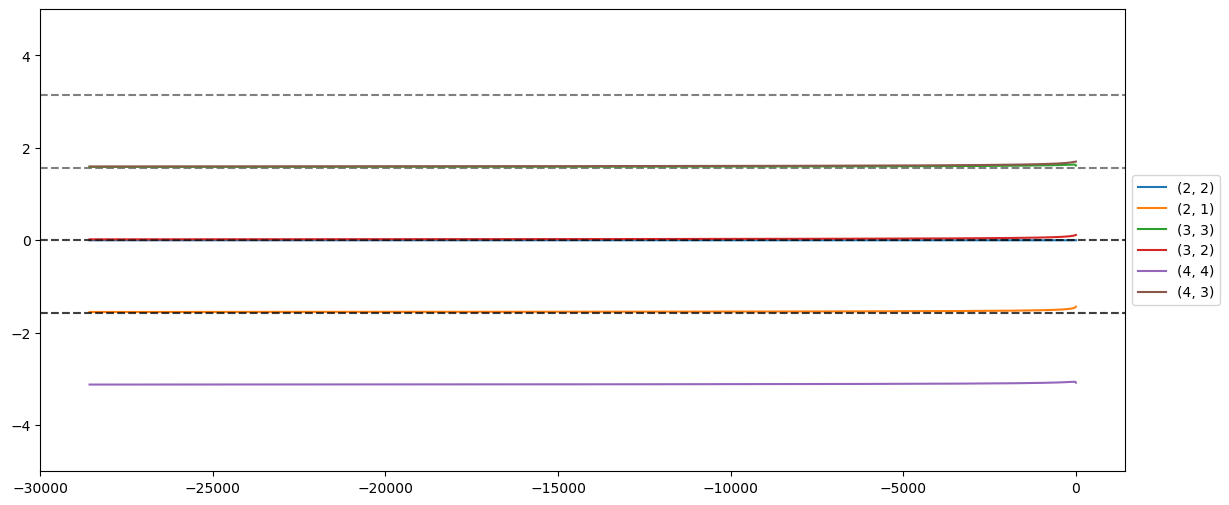

In [189]:
modes = [(2,2),(2,1),(3,3),(3,2),(4,4),(4,3)]
plt.figure(figsize=(14, 6), dpi=100)
# for mode in wf['hlm'].keys():
for mode in modes:
    ell=mode[0]
    mm=mode[1]
    plt.plot(wf['t'], wf['phase'][mode] - (wf['phase'][2,2]/2 * mm), label=mode)
    plt.axhline(delta_phi_fn(mm), c='k', ls='--', alpha=0.5)
plt.ylim(-5, 5)
# plt.xlim(-8000, 100)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [188]:
plt.figure(figsize=(14, 6), dpi=100)
ell = 3
mm = 2
mode = (ell, mm)

plt.plot(wf['t'], wf['phase'][mode] - (wf['phase'][2,2]/2 * mm), label=mode)
# plt.xlim(-8000, 100)